In [1]:
import pymc3 as pm
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as c
import theano.tensor as tt
from theano import shared
import pandas as pd
from scipy.special import gamma
from theano.compile.ops import as_op

In [2]:
elec_data = pd.read_csv('XZmulti_6_0.csv')
place_num=elec_data.place.unique()
place_l=len(place_num)
place=elec_data.place.values
place1=place-1

company_num = elec_data.company.unique()
company_l = len(company_num)
company = elec_data.company.values

year=elec_data.Year.values  # 观测时间值x1
year_num=elec_data.Year.unique()
year_l=len(year_num)



year1 = (year - np.mean(year)) / np.std(year)
elec_tem = elec_data.Tem.values  # 观测温度值x2
elec_tem1 = (elec_tem - np.mean(elec_tem)) / np.std(elec_tem)
elec_hPa = elec_data.hPa.values  # 观测压强x3
elec_hPa1 = (elec_hPa - np.mean(elec_hPa)) / np.std(elec_hPa)
elec_RH = elec_data.RH.values  # 观测压强x3
elec_RH1 = (elec_RH - np.mean(elec_RH)) / np.std(elec_RH)
# 计算故障率大小：故障数目/总测量数，作为模型Y值，放大1000倍以增加实际效果，结果中要缩小1000倍
# elec_fault = elec_data.Fault / elec_data.Nums
elec_faults = 1000 * (elec_data.Fault.values / elec_data.Nums.values)  # 数组形式
elec_faults1 = (elec_faults - np.mean(elec_faults)) / np.std(elec_faults)


elec_faults2 = np.array([elec_faults[i*6:(i+1)*6] for i in np.arange(21)])
elec_year2 = np.array([year[i*6:(i+1)*6] for i in np.arange(21)])

print(company)
print(year)
print(company_l)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[1 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1
 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2
 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6 1 2 3
 4 5 6 1 2 3 4 5 6 1 2 3 4 5 6]
3


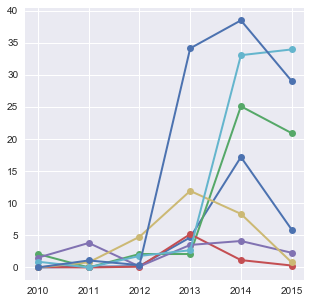

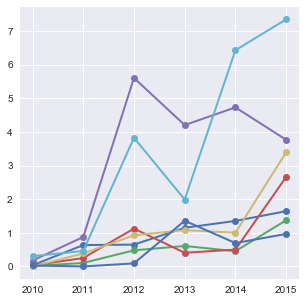

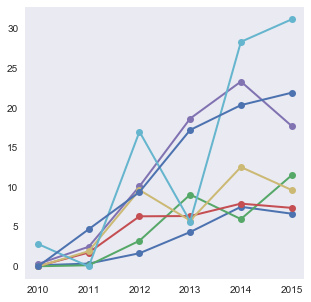

In [3]:
j, Num = 0, 6
fig=plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)
for m in range(7):
    ax1.plot(year[j:(j+Num)], elec_faults[j:(j+Num)], 'o-', linewidth=2)
    j = j+6
ax1.set_xticklabels(['2016','2010', '2011', '2012', '2013', '2014', '2015'])
fig2=plt.figure(figsize=(5,5))
ax2 = fig2.add_subplot(111)       
for m in range(7):
    ax2.plot(year[j:(j+Num)], elec_faults[j:(j+Num)],'o-', linewidth=2)
    j = j+6
ax2.set_xticklabels(['2016','2010', '2011', '2012', '2013', '2014', '2015'])
fig3=plt.figure(figsize=(5,5))
ax3 = fig3.add_subplot(111)
for m in range(7):
    ax3.plot(year[j:(j+Num)], elec_faults[j:(j+Num)],'o-', linewidth=2)
    j = j+6  
ax3.set_xticklabels(['2016','2010', '2011', '2012', '2013', '2014', '2015'])
plt.grid()
plt.show()

In [13]:
change = np.array([0 for i in np.arange(len(company))])
# change = np.array(company)
change[42:] = 0
change[:42] = 1
print(change)

def idvlogit(x):
    return tt.exp(x)/(tt.exp(x)+1)


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [29]:
with pm.Model() as pooling_model:
#     mu_3 = pm.Normal('mu_3', mu=0, sd=100)
#     sd_3 = pm.HalfCauchy('sd_3', 10)
#     mu_2 = pm.Normal('mu_2', mu=0, sd=100)
#     sd_2 = pm.HalfCauchy('sd_2', 10)
#     mu_1 = pm.Normal('mu_1', mu=0, sd=100)
#     sd_1 = pm.HalfCauchy('sd_1', 10)
#     mu_0 = pm.Normal('mu_0', mu=0, sd=100)
#     sd_0 = pm.HalfCauchy('sd_0', 10)
    beta1 = pm.GaussianRandomWalk('beta1', sd=1, shape=company_l)


    beta5 = pm.Normal('beta5', 0, 100)
    beta4 = pm.Deterministic('beta4', change*beta5*year*year)
    beta3 = pm.Normal('beta3', 0, 100)
    beta2 = pm.Normal('beta2', 0, 100)
#     beta1 = pm.Normal('beta1', 0, 100, shape=company_l)
    beta = pm.Normal('beta', 0, 100)
    
    alpha1 = pm.Normal('alpha1', 0, 20)
    alpha = pm.Normal('alpha', 0, 20)
    
    psi = pm.Deterministic('psi', idvlogit(alpha + alpha1*year))
    theta = pm.Deterministic('theta', tt.exp(beta + beta1[company] * year +  beta2 * elec_tem1 + beta3 * elec_hPa1 + beta4 ))
    
    aa = pm.HalfCauchy('aa', 10)
    Observed = pm.ZeroInflatedNegativeBinomial('Observed', psi =psi, mu =theta, alpha=aa, observed=elec_faults)  # 观测值
    
    start = pm.find_MAP()
    trace_1 = pm.sample(1000, start = start, njobs=1)

logp = -301.7, ||grad|| = 0.062042: 100%|██| 194/194 [00:00<00:00, 1416.02it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████████████████████████████████▉| 1498/1500 [01:15<00:00, 23.63it/s]E:\ProgramData\Anaconda3\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 179 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████████████████████████████████| 1500/1500 [01:15<00:00, 19.94it/s]


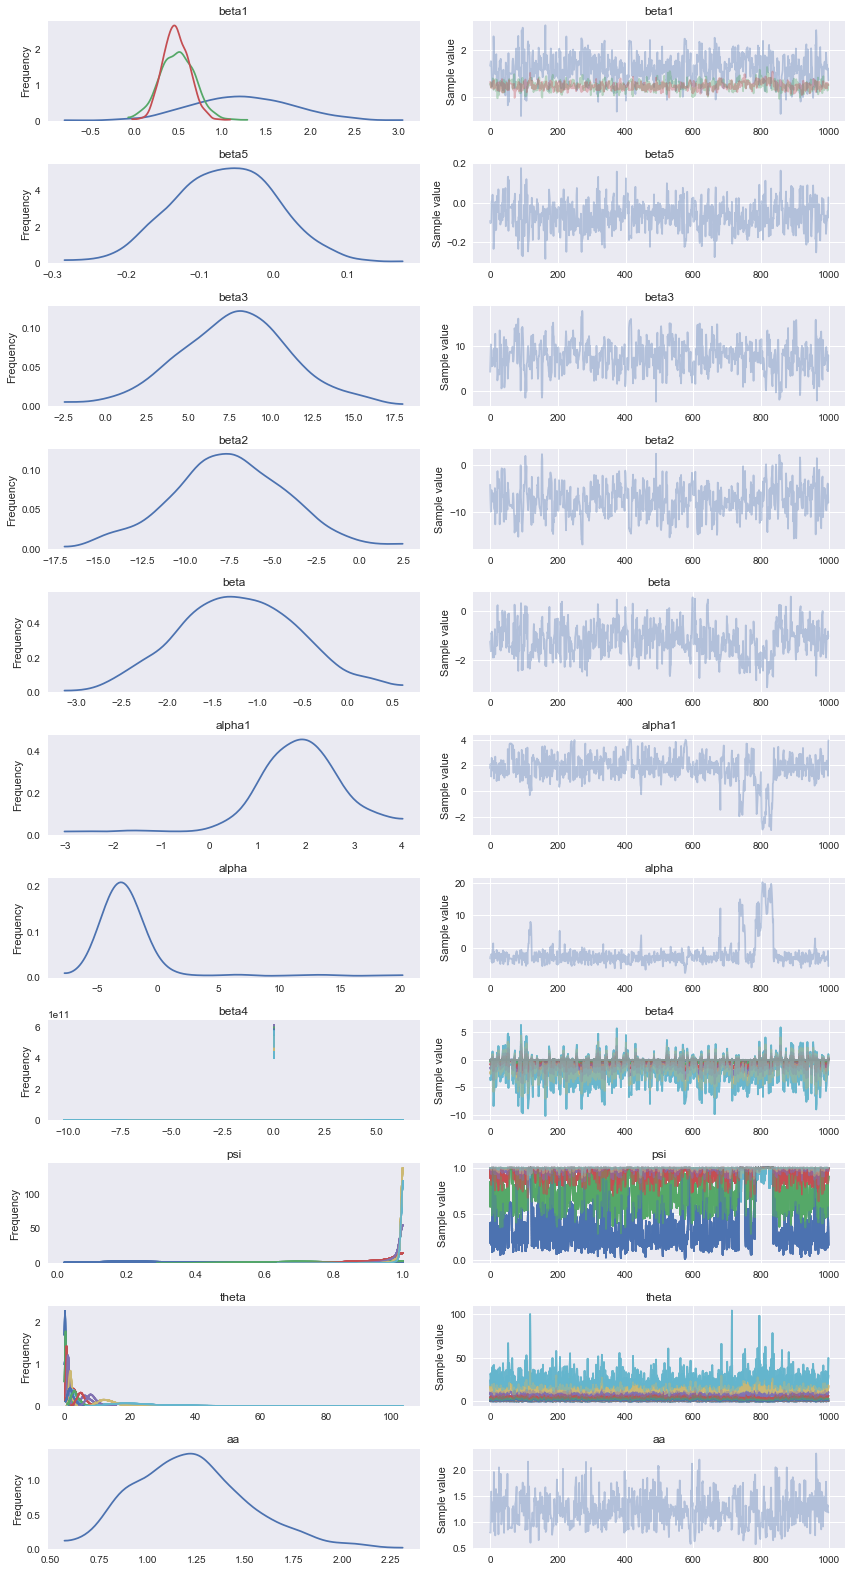

In [30]:
pm.traceplot(trace_1)
plt.show()

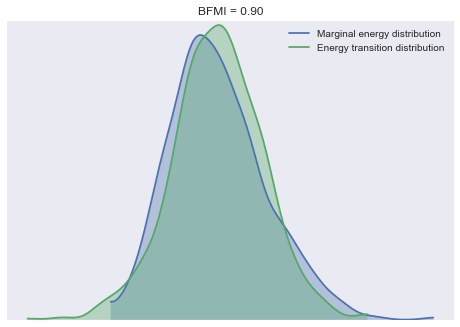

In [31]:
ax= pm.energyplot(trace_1)
bfmi = pm.bfmi(trace_1)
ax.set_title(f"BFMI = {bfmi:.2f}")
plt.show()

In [32]:
varnames2 = ['beta', 'beta1','beta2', 'beta3', 'beta5']
tmp = pm.df_summary(trace_1, varnames2)
print(tmp)
betaMAP = tmp['mean'][0]
beta1MAP = tmp['mean'][np.arange(company_l) + 1]
beta2MAP = tmp['mean'][1*company_l+1]
beta3MAP = tmp['mean'][1*company_l+2]
beta5MAP = tmp['mean'][ 1*company_l+3]
# uMAP = tmp['mean'][3*companiesABC+1]

print(betaMAP)
print(beta1MAP)
print(beta2MAP)
print(beta3MAP)
print('\n')
print(beta5MAP)
varnames1 = ['alpha', 'alpha1']
tmp0 = pm.df_summary(trace_1, varnames1)
alphaMAP = tmp0['mean'][0]
alpha1MAP = tmp0['mean'][1]
print(tmp0)

              mean        sd  mc_error    hpd_2.5   hpd_97.5
beta     -1.192740  0.661057  0.040817  -2.568194   0.032635
beta1__0  1.220332  0.567857  0.029172   0.251124   2.426434
beta1__1  0.490507  0.200878  0.010950   0.037530   0.831773
beta1__2  0.473837  0.151042  0.008355   0.189266   0.765587
beta2    -7.495104  3.342827  0.186920 -14.447697  -1.080743
beta3     7.795193  3.399321  0.192846   1.549240  15.254891
beta5    -0.065290  0.071409  0.003445  -0.190383   0.082873
-1.19273965996
beta1__0    1.220332
beta1__1    0.490507
beta1__2    0.473837
Name: mean, dtype: float64
-7.49510392831
7.79519341351


-0.065290210473
            mean        sd  mc_error   hpd_2.5   hpd_97.5
alpha  -1.702927  4.426273  0.386962 -6.283292  10.728786
alpha1  1.777437  1.106181  0.081644 -0.187950   4.013336


100%|████████████████████████████████████| 1000/1000 [00:00<00:00, 1102.50it/s]


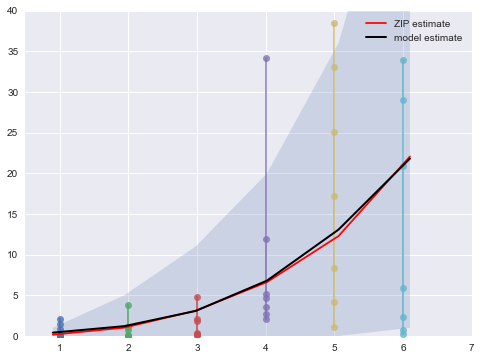

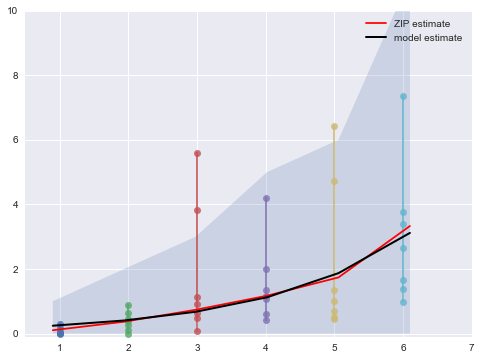

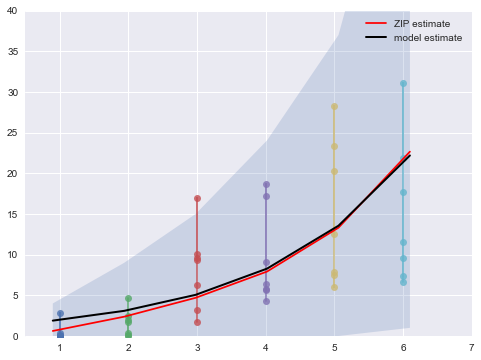

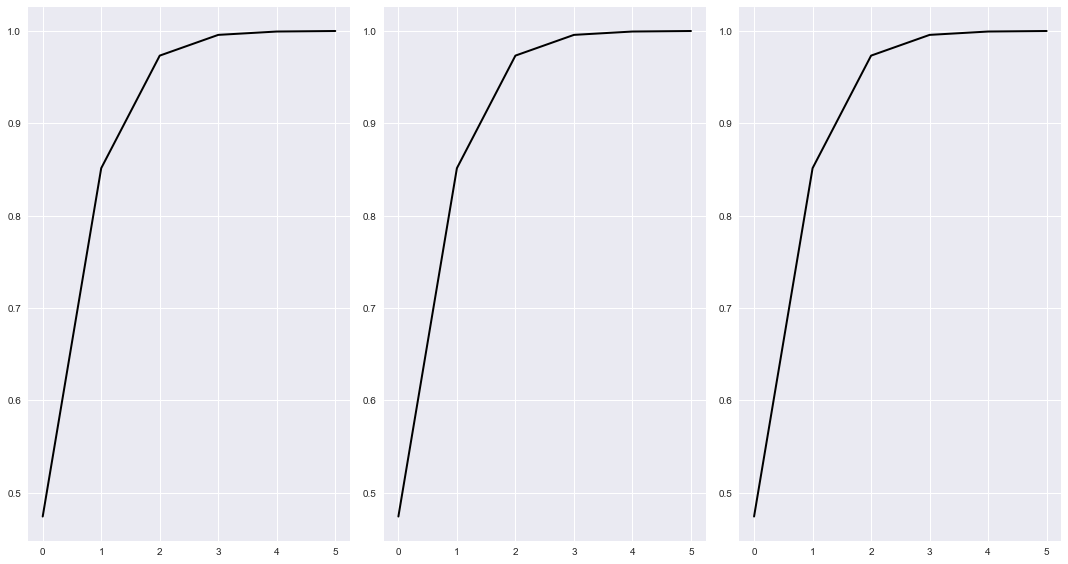

In [33]:
with pooling_model:
    pp_trace = pm.sample_ppc(trace_1, 1000)
low, high = np.percentile(pp_trace['Observed'], [5, 95], axis=0)

from matplotlib import gridspec
plt.figure(figsize=(8, 6))
gs = gridspec.GridSpec(1, 3)
# for ip in np.arange(company_l):
ip=0
ax = plt.subplot(1,1,1)
xp = elec_year2[ip*7:(ip+1)*7, :]   # 原始数据
yp = elec_faults2[ip*7:(ip+1)*7, :]
    
xl = np.linspace(0.9, 6.1, 6)
yl = np.exp(betaMAP + beta1MAP[ip]*xl + beta2MAP*elec_tem1[0:6]+ beta3MAP*elec_hPa1[0:6] + change[:6]*beta5MAP*xl*xl)
#     + beta2MAP*elec_tem1[ip*84:(ip*84+12)]
ax.plot(xp, yp, marker='o', alpha=.8)

ax.fill_between(xl, low[:6], high[:6],  alpha=0.2)
ax.plot(xl, pp_trace['Observed'].mean(axis=0)[:6], 'r', label="ZIP estimate")

ax.plot(xl, yl, 'k', linewidth=2, label="model estimate")
plt.axis([0.5, 7, -.1, 40])
ax.legend()
plt.show()

plt.figure(figsize=(8, 6))
ip=1
ax = plt.subplot(1,1,1)
xp = elec_year2[ip*7:(ip+1)*7, :]   # 原始数据
yp = elec_faults2[ip*7:(ip+1)*7, :]
    
xl = np.linspace(0.9, 6.1, 6)
yl = np.exp(betaMAP + beta1MAP[ip]*xl  + beta2MAP*elec_tem1[42:48]+ beta3MAP*elec_hPa1[42:48])
#     + beta2MAP*elec_tem1[ip*84:(ip*84+12)]
ax.plot(xp, yp, marker='o', alpha=.8)

ax.fill_between(xl, low[42:48], high[42:48],  alpha=0.2)
ax.plot(xl, pp_trace['Observed'].mean(axis=0)[42:48], 'r', label="ZIP estimate")

ax.plot(xl, yl, 'k', linewidth=2, label="model estimate")
plt.axis([0.5, 7, -.1, 10])
ax.legend()
plt.show()

plt.figure(figsize=(8, 6))
ip=2
ax = plt.subplot(1,1,1)
xp = elec_year2[ip*7:(ip+1)*7, :]   # 原始数据
yp = elec_faults2[ip*7:(ip+1)*7, :]
    
xl = np.linspace(0.9, 6.1, 6)
yl = np.exp(betaMAP + beta1MAP[ip]*xl + beta2MAP*elec_tem1[84:90]+ beta3MAP*elec_hPa1[84:90])
#     + beta2MAP*elec_tem1[ip*84:(ip*84+12)]
ax.plot(xp, yp, marker='o', alpha=.8)

ax.fill_between(xl, low[84:90], high[84:90],  alpha=0.2)
ax.plot(xl, pp_trace['Observed'].mean(axis=0)[84:90], 'r', label="ZIP estimate")

ax.plot(xl, yl, 'k', linewidth=2, label="model estimate")
plt.axis([0.5, 7, -.1, 40])
ax.legend()
plt.show()





plt.figure(figsize=(15, 8))
gs = gridspec.GridSpec(1, 3)
for ip in np.arange(company_l):
    ax = plt.subplot(gs[ip])
    y0 = alphaMAP + alpha1MAP*xl
    y00 = np.exp(y0)/(1+np.exp(y0))
    x0 = np.linspace(0.9, 6.1, 6)
    ax.plot(y00, 'k', linewidth=2)
# print(y0)
# print(y00)
plt.tight_layout()
plt.show()